### 병렬 실행을 위한 맵리듀스 브랜치 만들기
- 맵리듀스 : 객체 목록 생성 -> 각 객체에 대한 작업 수행(병렬 수행) -> 결과 결합
- 객체 목록이 정해지지 않아서 그래프를 생성하기 까다롭다. (랭그래프에서 지원하는 함수를 확인하는 것인 목표)
- RAG와 비슷한 패턴

### 주어진 토픽과 관련한 농담중에 베스트 농담 확인 예제 진행 절차
- 모델로부터 주어진 토픽과 관련된 주제를 받아서, 각 주제와 관련한 농담을 병렬로 실행한 후 결과를 합쳐서 베스트 농담 선정
1. State 정의 - 토픽, 병렬로 처리하기 위한 주제 리스트, 각 주제와 관련된 농담을 통합할 수 있는 농담 리스트, 베스트 농담
2. 병렬 처리를 고려한 노드 구성을 위한 클래스 생성, 함수 생성
3. 노드 구성 - 클로드 모델을 상용하며 프롬프트에 따라 문자열, 리스트를 리턴 함
4. 병렬 처리를 위해서 add_conditional_edges()를 활용하여 에지 구성(가변적인 주제에 맞게 농담을 가져오는 노드 연결) -> State에서 Reduce됨
5. 베스트 농담 처리
6. 결과값은 상태에 모두 저장되어 있음

### Required
- ANTHROPIC_API_KEY - [ANTHROP\C - Build with the Claude API](https://console.anthropic.com/dashboard)
- pyenv add langchain-anthropic

In [ ]:
%%capture --no-stderr
#%pip install -U langchain-anthropic langgraph

#### 랭스미스 연결, 키 연결

In [1]:
from dotenv import load_dotenv
load_dotenv('../envls')
import os
import getpass

def _set_env(name: str):
    if not os.getenv(name):
        os.environ[name] = getpass.getpass(f"{name}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [8]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add] # 개별 결과를 하나의 목록으로 결합
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".format()
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes) # 토픽과 농담을 활용하여 결과 출력, 이전 단계의 값들을 모두 활용
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

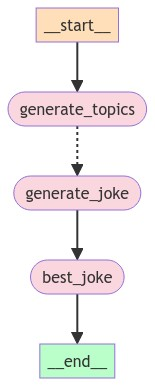

In [9]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [11]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['lion', 'elephant', 'penguin', 'giraffe']}}
{'generate_joke': {'jokes': ["Why don't giraffes ever get caught gossiping? Because they always stick their necks out for their friends!"]}}
{'generate_joke': {'jokes': ["Why don't penguins like online shopping? They're afraid of the web!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? They're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why don't lions like fast food? Because they can't catch it!"]}}
{'best_joke': {'best_selected_joke': "Why don't elephants use computers? They're afraid of the mouse!"}}



1. 기린들은 왜 절대 남의 험담하다 안 걸릴까요? 항상 친구들을 위해 목을 내밀기 때문이죠!
2. 펭귄들은 왜 온라인 쇼핑을 좋아하지 않을까요? 웹을 무서워하기 때문이죠!
3. 코끼리들은 왜 컴퓨터를 사용하지 않을까요? 마우스가 무서워서죠! (베스트 답변)
4. 사자들은 왜 패스트푸드를 좋아하지 않을까요? 잡을 수 없기 때문이죠!

### 랭스미스
1. 실패 - API키의 카드 연결이 되지 않았음

<img src="./images/Animal_error.png" width="800">

2. 성공 - 전체 결과, 단계별 결과 확인

<img src="./images/Animal_result.png" width="800">


### 결론
1. 초기 개념 잡기가 생각보다 쉽지 않다.
2. 많은 실습으로 경험과 활용법을 키워야 한다. -> 몸이 기억할 수 있도록 연습해야 함
3. 추가로 배워야할 내용이 적다.
4. [LangGraph Example](https://github.com/langchain-ai/langgraph/tree/main)  
    - [force-calling-a-tool-first](https://github.com/langchain-ai/langgraph/blob/main/examples/chat_agent_executor_with_function_calling/force-calling-a-tool-first.ipynb)